# Data assimilation exercise

In [1]:
using Random
using LinearAlgebra
using Statistics

using DataAssim
using NCDatasets
using Interpolations
using GeoMapping
using PyPlot

┌ Info: Recompiling stale cache file /home/abarth/.julia/compiled/v1.1/DataAssim/qCDwD.ji for DataAssim [cf87cc76-4620-5dad-9f0a-7411b2d39d18]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/abarth/.julia/compiled/v1.1/GeoMapping/D3x4o.ji for GeoMapping [5337e22b-f35c-538d-b59b-22628e187084]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/abarth/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


Download the data (if necessary)

In [2]:
if !isdir("data")
    mkdir("data")
end

if !isfile("data/ensemble_surface.nc")
    download("https://dox.uliege.be/index.php/s/WKweU7pRtPqlwRK/download","data/ensemble_surface.nc")
end

if !isfile("data/LS2v.nc")
    download("https://dox.uliege.be/index.php/s/k2AaF1ETWDGUsg3/download","data/LS2v.nc")
end


In [3]:
"""
Compute the RMS difference between a and b
"""
rms(a,b) = sqrt(mean((a - b).^2))

rms

In [4]:
"""
x = packsv(mask_u,mask_v,u,v)
combine the velocity field with the component u and v
in a single state vector where the corresponding elements of
the masks mask_u and mask_v are true"""
function packsv(mask_u,mask_v,u,v)
    return [u[mask_u]; v[mask_v]]
end

packsv

In [5]:
"""
u,v = unpacksv(mask_u,mask_v,x)
Extract from a state vector x the compoennts u and v. It is the reverse operation of packsv.
"""
function unpacksv(mask_u,mask_v,x)
    n = sum(mask_u)
    u = fill(NaN,size(mask_u))
    v = fill(NaN,size(mask_v))
    u[mask_u] = x[1:n]
    v[mask_v] = x[n+1:end]
    return u,v
end

unpacksv

In [6]:
"convert km to arc degree on the surface of the Earth"
km2deg(x) = 180 * x / (pi * 6371)

km2deg

In [7]:
"""
lonobs,latobs,Bearing = radarobsloc(lon0,lat0,r,bearing)
Compute the location of the radial velocities covered by an HF radar site located at lon0,lat0. The vector r are the ranges (in km) and bearing are the angles (in degree). It also returns the matrix Bearing which has the same size as the matrices lonobs and latobs where the bearing angle is repeated for the different ranges.
"""

function radarobsloc(lon0,lat0,r,bearing)

    sz = (length(r),length(bearing))
    latobs = zeros(sz)
    lonobs = zeros(sz)
    Bearing = zeros(sz)

    for j = 1:length(bearing)
        for i = 1:length(r)
            Bearing[i,j] = bearing[j]
            latobs[i,j],lonobs[i,j] = reckon(lat0, lon0,
                                             km2deg(r[i]), bearing[j])
        end
    end

    return lonobs,latobs,Bearing
end

radarobsloc (generic function with 1 method)

In [8]:
"""
plotvel(u,v; legendvec = 1)
Plot the vector field with the comonents u and v. The parameter legendvec is an optional argument representing the length of the legend vector
"""

function plotvel(u,v; legendvec = 1)
    us = (u[1:end-1,2:end-1] + u[2:end,2:end-1]) / 2.
    vs = (v[2:end-1,1:end-1] + v[2:end-1,2:end]) / 2.
    r = 5

    ur = us[1:r:end,1:r:end]
    vr = vs[1:r:end,1:r:end]
    lonr = lon[2:end-1,2:end-1][1:r:end,1:r:end]
    latr = lat[2:end-1,2:end-1][1:r:end,1:r:end]

    ur[end-7,end-3] = legendvec
    vr[end-7,end-3] = 0
    contourf(lon,lat,mask,levels = [0.,0.5],colors = [[.5,.5,.5]])
    quiver(lonr,latr,ur,vr)
end

plotvel (generic function with 1 method)

In [9]:
"""
ur = interp_radvel(lon_u,lat_u,lon_v,lat_v,us,vs,lonobs,latobs,bearingobs)
Interpolate and rotate the velocity vertors to compute the radial velcity `ur`.
Return only the radial velocity over sea.
"""
function interp_radvel(lon_u,lat_u,lon_v,lat_v,us,vs,lonobs,latobs,bearingobs)
    itpu = extrapolate(interpolate((lon_u[:,1],lat_u[1,:]),us,Gridded(Linear())),NaN)
    itpv = extrapolate(interpolate((lon_v[:,1],lat_v[1,:]),vs,Gridded(Linear())),NaN)

    ur = zeros(size(lonobs))
    for i = 1:length(lonobs)
        direction = (bearingobs[i] + 180) * pi/180
        ur[i] = sin(direction) * itpu(lonobs[i],latobs[i]) + cos(direction) * itpv(lonobs[i],latobs[i])
    end

    return ur[.!isnan.(ur)]
end

interp_radvel

In [10]:
# location of the data
# @__FILE__is the path of the current file
datadir = joinpath(dirname(@__FILE__),"data")

# load the NetCDF varibles u and v
fname = joinpath(datadir,"ensemble_surface.nc")
nc = Dataset(fname)
u = nomissing(nc["u"][:,:,:],NaN)
v = nomissing(nc["v"][:,:,:],NaN)
close(nc)

In [11]:
# load the model grid

gridname = joinpath(datadir,"LS2v.nc")
nc = Dataset(gridname);
lon_u = nomissing(nc["lon_u"][:,:])
lat_u = nomissing(nc["lat_u"][:,:])
lon_v = nomissing(nc["lon_v"][:,:])
lat_v = nomissing(nc["lat_v"][:,:])
lon = nomissing(nc["lon_rho"][:,:])
lat = nomissing(nc["lat_rho"][:,:])
# mask is just used for drawing the coastline
mask = nomissing(nc["mask_rho"][:,:])
# mask_u/mask_v are true where a grid cell is a sea point (and zero where it is a land point)
mask_u = nomissing(nc["mask_u"][:,:]) .== 1
mask_v = nomissing(nc["mask_v"][:,:]) .== 1
close(nc)

In [12]:
# location of the HF radar

sitelon1 = 9.84361
sitelat1 = 44.04167
siteorientation1 = 240

sitelon2 = 10.46
sitelat2 = 43.37
siteorientation2 = 240

# location of the observations

ranges = 5:5:100

lonobs1,latobs1,bearingobs1 = radarobsloc(sitelon1,sitelat1,ranges,siteorientation1 .+ (-60:5:60))
lonobs2,latobs2,bearingobs2 = radarobsloc(sitelon2,sitelat2,ranges,siteorientation2 .+ (-60:5:60))

bearingobs = bearingobs1[:]
lonobs = lonobs1[:]
latobs = latobs1[:]

bearingobs = [bearingobs1[:]; bearingobs2[:]]
lonobs = [lonobs1[:]; lonobs2[:]]
latobs = [latobs1[:]; latobs2[:]]




# clf()
# figure(1)

# contourf(lon,lat,mask,levels = [0.,0.5],colors = [[.5,.5,.5]])

# plot(sitelon1,sitelat1,"x")
# plot(lonobs1[:],latobs1[:],".")
# plot(sitelon2,sitelat2,"x")
# plot(lonobs2[:],latobs2[:],".")

# the true state
xt = packsv(mask_u,mask_v,u[:,:,end],v[:,:,end])

# number of elements in the state vector
n = sum(mask_u) + sum(mask_v)

# Ensemble size
Nens = size(u,3)-1

# Matrix with all ensemble members in "packed" form
Xf = zeros(n,Nens)
for n = 1:Nens
    Xf[:,n] = packsv(mask_u,mask_v,u[:,:,n],v[:,:,n])
end

# ensemble mean
xf = mean(Xf, dims = 2)

u3,v3 = unpacksv(mask_u,mask_v,xt)

yo = interp_radvel(lon_u,lat_u,lon_v,lat_v,u[:,:,end],v[:,:,end],lonobs,latobs,bearingobs)

R = Diagonal(fill(0.2,size(yo)))

# set the seed
Random.seed!(12345)

# add noise to yo
yo = yo + sqrt(R) * randn(size(yo))

HXf = zeros(length(yo),size(u,3)-1)

# apply the observation operator to every velocity field
for i = 1:size(u,3)-1
    HXf[:,i] = interp_radvel(lon_u,lat_u,lon_v,lat_v,u[:,:,i],v[:,:,i],lonobs,latobs,bearingobs)
end

# apply the ETKF

Xa,xa = ETKF(Xf,HXf,yo,R,[])

# extract the velocity from the state vector
uf,vf = unpacksv(mask_u,mask_v,xf)
ua,va = unpacksv(mask_u,mask_v,xa)

([0.0428274 0.0354537 … NaN NaN; 0.0502005 0.0498783 … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], [-0.0861358 -0.0741335 … NaN NaN; -0.0981379 -0.138217 … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN])

In [13]:
# compute the RMS errors
@show rms(xf,xt)
@show rms(xa,xt)

rms(xf, xt) = 0.11449592021540822
rms(xa, xt) = 0.06824418761888755


0.06824418761888755

In [14]:
rms_velocity = rms(xa,xt)

0.06824418761888755

In [15]:
# groupname = "mygroup"

us = (u[1:end-1,2:end-1,:] + u[2:end,2:end-1,:]) / 2.
vs = (v[2:end-1,1:end-1,:] + v[2:end-1,2:end,:]) / 2.


varvel = var(us,dims=3) + var(vs,dims=3)
varvel = varvel[:,:,1];

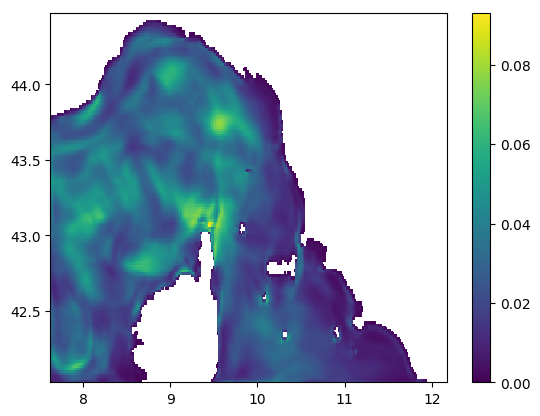

In [16]:
figure()
varvel[mask[2:end-1,2:end-1] .== 0] .= NaN
pcolor(lon[2:end-1,2:end-1],lat[2:end-1,2:end-1],varvel)
colorbar()

normvel = sqrt.(us.^2 + vs.^2);
prob = mean(normvel .> 0.2, dims = 3)
prob = prob[:,:,1]
prob[mask[2:end-1,2:end-1] .== 0] .= NaN;

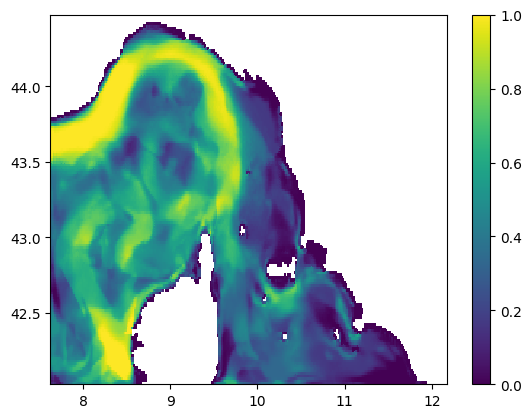

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff3947c9630>

In [17]:
figure()
pcolor(lon[2:end-1,2:end-1],lat[2:end-1,2:end-1],prob)
colorbar()

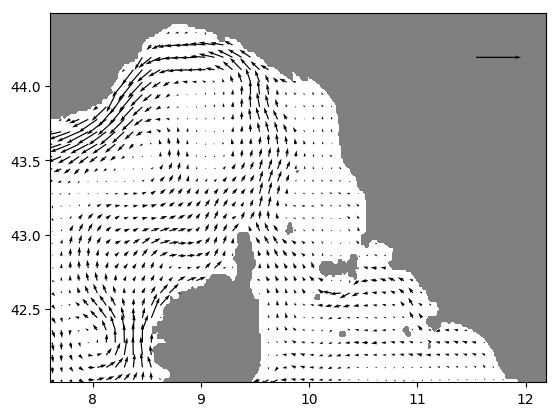

(Figure(PyObject <Figure size 640x480 with 1 Axes>), PyObject <matplotlib.quiver.Quiver object at 0x7ff39473a518>)

In [18]:
figure(),plotvel(uf,vf; legendvec = 1)

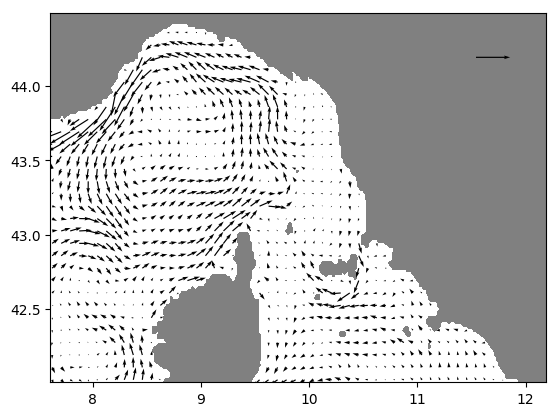

(Figure(PyObject <Figure size 640x480 with 1 Axes>), PyObject <matplotlib.quiver.Quiver object at 0x7ff394663668>)

In [19]:
figure(),plotvel(ua,va; legendvec = 1)